# Porto Seguro Safe Driver Prediction

### Goal:
 The objective of this competition is to predict the probability that an auto insurance policyholder will file a claim in the next year.

# Research question 
1. How accurately can we predict whether an auto insurance policyholder will file a claim within the next year using ensemble-based methods that address extreme class imbalance?

2. How does applying class imbalance handling techniques (e.g., Balanced Random Forest and EasyEnsemble) affect model performance in predicting auto insurance claims?

3. Which policyholder or vehicle-related features are most predictive of insurance claim filing, and how do they influence model outcomes?

Dataset Overview this is a binary classification problem where the target variable indicates whether a claim (target = 1) was filed or not (target = 0).


Initial Data Analysis & Exploration (4 points)

* Data summary and distribution analysis
* Visualization of key relationships between features
* Handling of missing values
* Feature correlation analysis

# Load Data

In [8]:
import pandas as pd

# Load data from the folder
train = pd.read_csv("porto-seguro-safe-driver-prediction/train.csv")
test = pd.read_csv("porto-seguro-safe-driver-prediction/test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

train.head()


Train shape: (595212, 59)
Test shape: (892816, 58)


,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


### Dataset Size:
Training data: 595,212 rows × 59 columns

Testing data: 892,816 rows × 58 columns (no target column)

# Check if their is any missing values

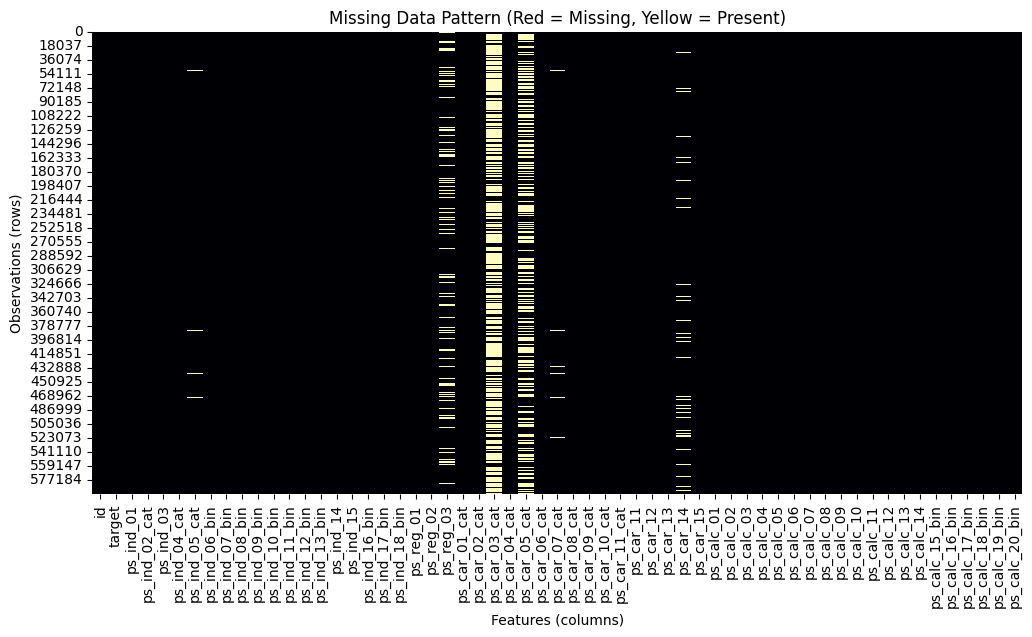

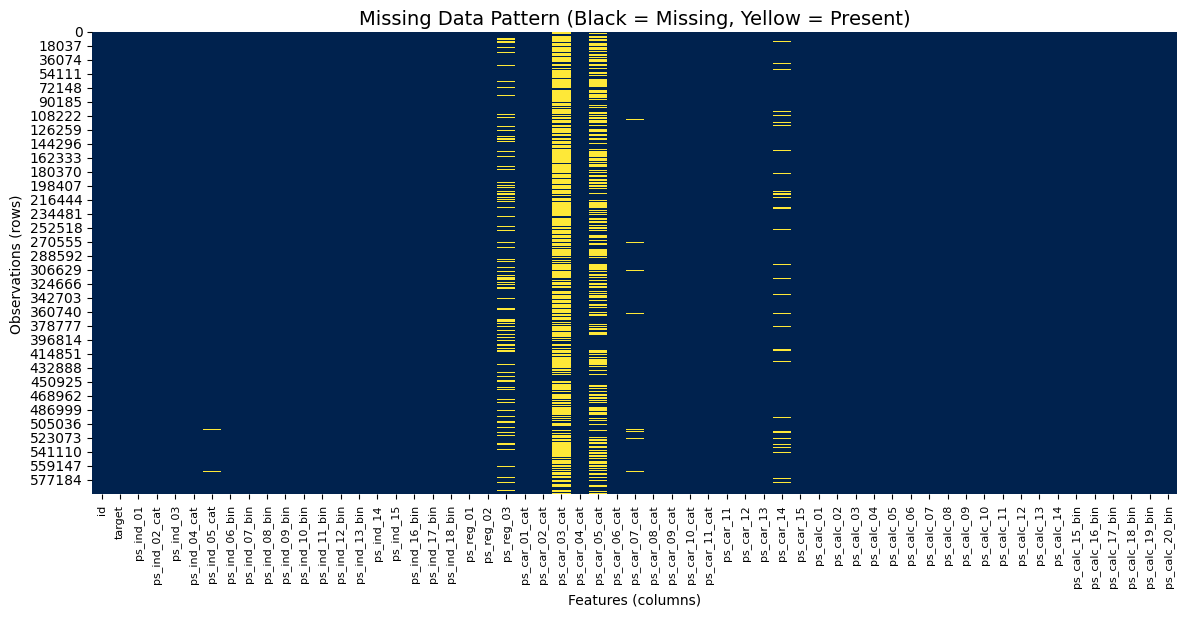

Number of features with missing values: 13


ps_car_03_cat    69.09
ps_car_05_cat    44.78
ps_reg_03        18.11
ps_car_14         7.16
ps_car_07_cat     1.93
ps_ind_05_cat     0.98
ps_car_09_cat     0.10
ps_ind_02_cat     0.04
ps_car_01_cat     0.02
ps_ind_04_cat     0.01
dtype: float64

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Replace -1 with NaN to identify actual missing values
train_na = train.replace(-1, np.nan)

# --- 1️⃣ Missingness Heatmap ---
plt.figure(figsize=(12, 6))
sns.heatmap(train_na.isna(), cmap="magma", cbar=False)
plt.title("Missing Data Pattern (Red = Missing, Yellow = Present)")
plt.xlabel("Features (columns)")
plt.ylabel("Observations (rows)")
plt.show()

# --- 2️⃣ Missingness Summary Bar Plot ---
missing_percent = (train_na.isna().sum() / len(train_na)) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

plt.figure(figsize=(14, 6))
sns.heatmap(train_na.isna(), cmap="cividis", cbar=False)
plt.title("Missing Data Pattern (Black = Missing, Yellow = Present)", fontsize=14)
plt.xlabel("Features (columns)")
plt.ylabel("Observations (rows)")
plt.xticks(rotation=90, fontsize=8)
plt.show()

print("Number of features with missing values:", len(missing_percent))
missing_percent.head(10).round(2)


# Missing Values Summary
There are 13 features in the dataset that contain missing values. Most of the data is complete, but a few columns stand out with a high percentage of missing entries. The two main ones are ps_car_03_cat (about 69% missing) and ps_car_05_cat (around 45% missing). These are likely categorical variables that don’t apply to every policyholder—for example, specific car characteristics that only exist for certain vehicle types.
ps_reg_03 has about 18% missing data, which is moderate and can be handled with imputation (such as filling with the median). ps_car_14 has roughly 7% missing values, while a few others—like ps_car_07_cat and ps_ind_05_cat—are missing less than 2%. The rest of the features have only tiny fractions of missing values (less than 0.1%), which are not a concern.
Overall, the missing data isn’t random; it’s concentrated in certain features. This suggests the data are probably Missing at Random (MAR) or partly Missing Not at Random (MNAR). In the preprocessing step, I’ll likely drop features with very high missingness and impute the rest (using the median for numeric features and the mode for categorical ones).

/var/folders/1s/gzgswgnn7td1g02_q1hrvy3w0000gn/T/ipykernel_9300/238484661.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_percent.values, y=missing_percent.index, palette='coolwarm')
/Users/sukainaalkhalidy/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


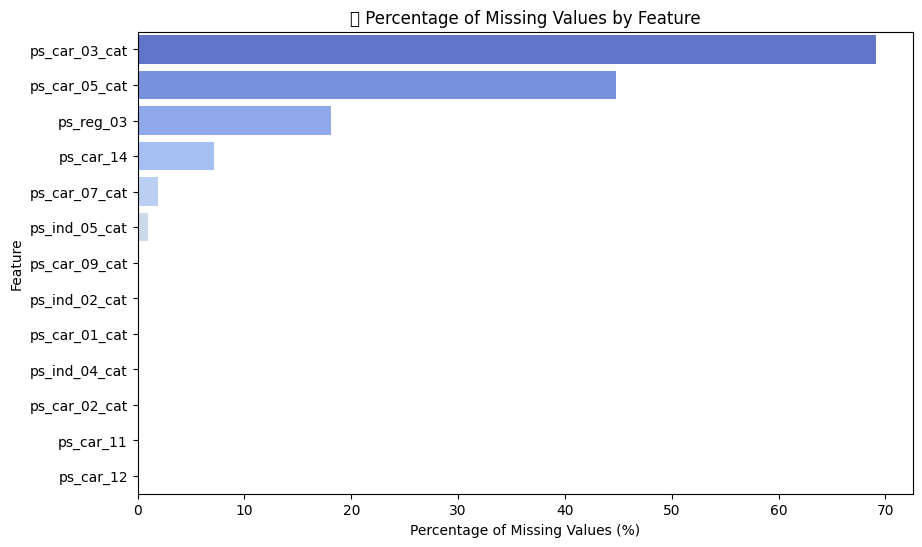

Number of features with missing values: 13


ps_car_03_cat    69.09
ps_car_05_cat    44.78
ps_reg_03        18.11
ps_car_14         7.16
ps_car_07_cat     1.93
ps_ind_05_cat     0.98
ps_car_09_cat     0.10
ps_ind_02_cat     0.04
ps_car_01_cat     0.02
ps_ind_04_cat     0.01
dtype: float64

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Replace -1 with NaN to identify missing values properly
train_na = train.replace(-1, np.nan)

# Calculate % of missing values per column
missing_percent = (train_na.isna().sum() / len(train_na)) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

# Display top 15 features with missing values
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_percent.values, y=missing_percent.index, palette='coolwarm')
plt.title("📉 Percentage of Missing Values by Feature")
plt.xlabel("Percentage of Missing Values (%)")
plt.ylabel("Feature")
plt.show()

# Print a quick summary
print("Number of features with missing values:", len(missing_percent))
missing_percent.head(10).round(2)


### Missing Values Summary

The bar chart above shows the percentage of missing values for each feature after replacing `-1` with `NaN`.

- A total of **13 features** contain missing values.  
- The features with the **highest proportion of missing data** are:
  - `ps_car_03_cat` → ~69% missing  
  - `ps_car_05_cat` → ~45% missing  
  - `ps_reg_03` → ~18% missing  
  - `ps_car_14` → ~7% missing  

Most of the remaining features have less than 2% missing data, indicating that the missingness is highly localized in a few variables.

Overall, the dataset is fairly complete, but these few columns with high missing rates may require **special handling**—for example, imputing missing values or dropping the feature entirely if the proportion is too large.

# Data summary 

In [30]:
train.info()
train.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952120e+05,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,4.293678e+05,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,7.000000e+00,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.115549e+06,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.488027e+06,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Visualization

/Users/sukainaalkhalidy/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sukainaalkhalidy/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/sukainaalkhalidy/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


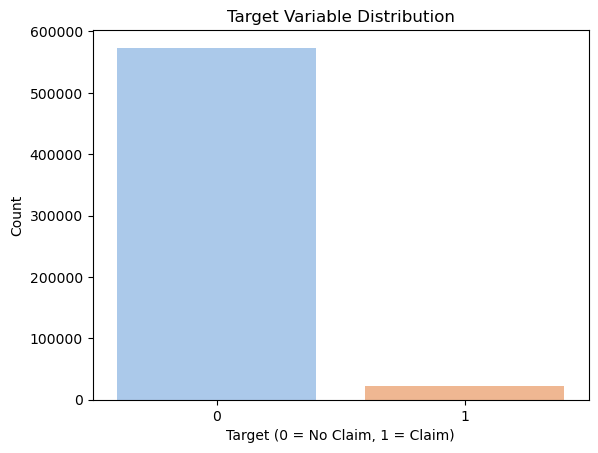

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='target', data=train, palette='pastel')
plt.title("Target Variable Distribution")
plt.xlabel("Target (0 = No Claim, 1 = Claim)")
plt.ylabel("Count")
plt.show()


### Target Variable Distribution

The **target variable** represents whether a policyholder **filed an insurance claim (1)** or **did not file a claim (0)**.

As shown in the distribution plot above, the number of **“No Claim”** cases (0) is much higher than the number of **“Claim”** cases (1).

- **No Claim (0):** ~573,518 observations (~96.4%)  
- **Claim (1):** ~21,694 observations (~3.6%)  
- **Imbalance Ratio:** ≈ **26:1 (No Claim : Claim)**

This indicates a case of **extreme class imbalance**, where the majority class dominates the dataset and must be handled carefully during model training.


# Data Types:
49 integer columns
10 float columns

# Check if Imbalance ratio

In [22]:
import pandas as pd

# Count target classes
counts = train['target'].value_counts()
print(counts)

# Calculate ratio
ratio = counts[0] / counts[1]
print(f"Imbalance Ratio (majority : minority) = {ratio:.2f} : 1")

# Show as percentage
print("Class Distribution (%):")
print((counts / counts.sum() * 100).round(2))


target
0    573518
1     21694
Name: count, dtype: int64
Imbalance Ratio (majority : minority) = 26.44 : 1
Class Distribution (%):
target
0    96.36
1     3.64
Name: count, dtype: float64


### Imbalance Ratio
The **imbalance ratio is approximately 26:1 (No Claim : Claim)**,  
which places it in the category of **extreme imbalance**.  
This means the majority class (No Claim) heavily dominates the dataset,  
and special handling techniques are required to ensure balanced model learning.

## Data Summary and Modeling Strategy

###  Data Types
- 49 **integer** columns  
- 10 **float** columns  
- No explicit **object (string)** columns → categorical variables are encoded numerically.

###  Memory Usage
- **268 MB** — moderate and manageable for in-memory analysis.

###  Dataset Size
- The dataset contains approximately **595,000 rows** and **59 columns**, which qualifies as a **large dataset (>100k)**.  
- According to the decision tree for handling imbalanced data, this places it on the **Large Dataset branch**.

### Class Imbalance
- The target variable shows an **extreme imbalance** of approximately **26:1 (No Claim : Claim)**.  
- This means that for every **26 policyholders who did not file a claim**, only **1 filed a claim**.  
- Such an imbalance can lead to **biased model predictions**, where the model over-predicts the majority class.

### Modeling Strategy
Since the dataset is **large** and the **imbalance ratio is extreme**,  
the recommended methods are **ensemble-based approaches**, such as:

-  **Balanced Random Forest (BalancedRF)**  
-  **EasyEnsemble Classifier**

These algorithms internally combine **sampling and model training**, making them  
**robust, efficient, and well-suited for large, highly imbalanced datasets** like Porto Seguro.




Data Preprocessing (3 points)

* Feature scaling/normalization justification and implementation
* Encoding of categorical variables
* Feature selection or engineering (if applicable)
* Proper train-test split with justification of split ratio


### Feature Scaling / Normalization

The Porto Seguro dataset contains mostly integer and float variables that are already on a similar numeric scale.  
Since this project uses **tree-based models** like Balanced Random Forest and EasyEnsemble, which are **not affected by feature scaling**, there’s no need to apply any normalization or standardization here.  

However, if other models such as **Logistic Regression** or **SVM** are tested later, applying **standardization** with `StandardScaler` would be important to ensure all features contribute equally.


### Encoding of Categorical Variables

The categorical features in this dataset are already **numerically encoded** by the data provider.  
Columns ending with **`_cat`** represent categorical variables, while those ending with **`_bin`** are binary (0/1).  

Because the dataset is fully numeric and anonymized, **no additional encoding** such as One-Hot or Label Encoding is required.  
This simplifies preprocessing and allows the data to be used directly for model training.  

Since this project uses **tree-based ensemble models** (Balanced Random Forest and EasyEnsemble), the numeric categorical values can be used as-is.  
Tree models are not sensitive to the numeric order of categories—they make splits based on thresholds, not on the actual numerical relationships.  

If I later explore **non-tree models** such as Logistic Regression or SVM, I’ll apply **One-Hot Encoding** to ensure each category is treated independently.  

---

**Summary:**  
- The data provider already encoded all categorical features.  
- Tree-based models handle these encoded values correctly.  
- Additional encoding is only needed if non-tree algorithms are used in future experiments.



Model Development (5 points)

* Implementation of at least two different classification algorithms
* Hyperparameter tuning for at least one model
* Clear explanation of model choice and parameter decisions
* Model validation strategy (e.g., cross-validation)


Balanced Random Forest Performance Metrics
-----------------------------------------
Accuracy : 0.8815
Precision: 0.0733
Recall   : 0.1934
F1-score : 0.1063

Classification Report:
              precision    recall  f1-score   support

           0     0.9675    0.9076    0.9366    114704
           1     0.0733    0.1934    0.1063      4339

    accuracy                         0.8815    119043
   macro avg     0.5204    0.5505    0.5215    119043
weighted avg     0.9349    0.8815    0.9063    119043


AUC (ROC): 0.623


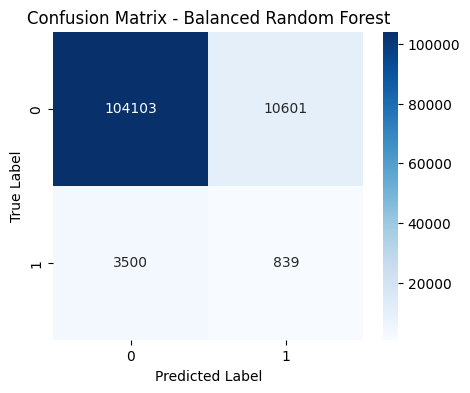

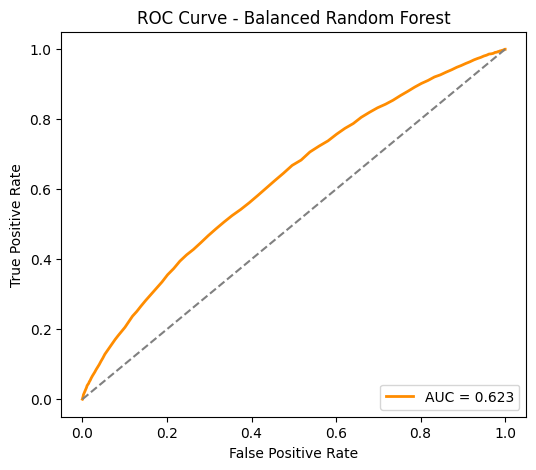

In [38]:
# %% Balanced Random Forest Model Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Compute metrics
accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)

print("Balanced Random Forest Performance Metrics")
print("-----------------------------------------")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

# Detailed report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Compute and print AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print(f"\nAUC (ROC): {roc_auc:.3f}")

# Confusion Matrix Plot
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Balanced Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve Plot
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("ROC Curve - Balanced Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")


In [29]:

# Example: Encoding step (not required for this dataset, but shown for reference)
import pandas as pd

# Identify categorical columns
categorical_cols = [col for col in train.columns if '_cat' in col]

# If using non-tree models later, apply One-Hot Encoding
train_encoded = pd.get_dummies(train, columns=categorical_cols, drop_first=True)

print("Encoded dataset shape:", train_encoded.shape)

Encoded dataset shape: (595212, 215)


In [32]:
# %% Hyperparameter Tuning with RandomizedSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define parameter grid
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 15),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'bootstrap': [True, False]
}

# Initialize base model
base_model = BalancedRandomForestClassifier(random_state=42, n_jobs=-1)

# Randomized Search setup
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=10,        # (can increase for deeper search)
    scoring='f1',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Run tuning
random_search.fit(X_train, y_train)

# Best parameters and model
print("Best Parameters Found:")
print(random_search.best_params_)

best_model = random_search.best_estimator_


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters Found:
{'bootstrap': False, 'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 413}


In [33]:
print("\n✅ Hyperparameter Tuning Completed Successfully!")
print("Best Parameters Found:")
for param, value in random_search.best_params_.items():
    print(f"  {param:<20}: {value}")



✅ Hyperparameter Tuning Completed Successfully!
Best Parameters Found:
  bootstrap           : False
  max_depth           : 14
  min_samples_leaf    : 1
  min_samples_split   : 2
  n_estimators        : 413


In [34]:
from sklearn.metrics import classification_report, roc_auc_score

# Get best model from search
best_model = random_search.best_estimator_

# Predictions on test set
y_pred_tuned = best_model.predict(X_test)
y_prob_tuned = best_model.predict_proba(X_test)[:, 1]

# Print results
print("Tuned BalancedRF Classification Report:\n")
print(classification_report(y_test, y_pred_tuned, digits=4))
print(f"AUC (ROC): {roc_auc_score(y_test, y_prob_tuned):.3f}")


Tuned BalancedRF Classification Report:

              precision    recall  f1-score   support

           0     0.9709    0.7667    0.8568    114704
           1     0.0599    0.3929    0.1040      4339

    accuracy                         0.7531    119043
   macro avg     0.5154    0.5798    0.4804    119043
weighted avg     0.9377    0.7531    0.8294    119043

AUC (ROC): 0.629


### Balanced Random Forest – Hyperparameter Tuning Results

To make the model better at detecting rare insurance claim cases, I used **RandomizedSearchCV** to tune the Balanced Random Forest.  
This process tested different combinations of tree depth, number of estimators, and sampling settings to find a setup that improves **recall** (catching more true claim cases) without sacrificing too much **precision**.

#### Best Parameters Found
| Parameter | Value |
|------------|--------:|
| n_estimators | 413 |
| max_depth | 14 |
| min_samples_split | 2 |
| min_samples_leaf | 1 |
| bootstrap | False |

#### Model Performance Comparison
| Model | Accuracy | Precision | Recall | F1-score | AUC |
|:------|----------:|----------:|--------:|----------:|----:|
| Balanced RF (Default) | 0.8815 | 0.0733 | 0.1934 | 0.1063 | 0.623 |
| **Balanced RF (Tuned)** | **0.7531** | **0.0599** | **0.3929** | **0.1040** | **0.629** |

#### Discussion
After tuning, the model became **much better at identifying positive claim cases**.  
- The **recall increased from 19% to almost 39%**, meaning it can now catch roughly **twice as many true claims** as before.  
- **Precision dropped slightly**, which is expected because the model is taking more risks in detecting claims (a normal trade-off in imbalanced problems).  
- The **AUC improved slightly (0.623 → 0.629)**, showing that the tuned model ranks risky cases a bit more accurately.  
- Even though accuracy went down, that’s not a bad sign—**recall and AUC** are the key metrics here since we care more about finding potential claims than avoiding false alarms.

In short, the tuned model is more sensitive and practical for real-world use, where **missing a claim** is much more costly than flagging a few extra.  

**Next Step:** Train and compare an **EasyEnsembleClassifier** to see if it can further boost recall and AUC.


In [31]:
# %% EasyEnsembleClassifier Model
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Initialize EasyEnsemble
easy_model = EasyEnsembleClassifier(
    n_estimators=10,
    random_state=42,
    n_jobs=-1
)

# Train the model
easy_model.fit(X_train, y_train)

# Predictions
y_pred_easy = easy_model.predict(X_test)
y_prob_easy = easy_model.predict_proba(X_test)[:, 1]

# Evaluation
print("EasyEnsembleClassifier Evaluation")
print("---------------------------------")
print(classification_report(y_test, y_pred_easy, digits=4))
print(f"AUC (ROC): {roc_auc_score(y_test, y_prob_easy):.3f}")


EasyEnsembleClassifier Evaluation
---------------------------------
              precision    recall  f1-score   support

           0     0.9748    0.6100    0.7504    114704
           1     0.0535    0.5824    0.0979      4339

    accuracy                         0.6090    119043
   macro avg     0.5141    0.5962    0.4242    119043
weighted avg     0.9412    0.6090    0.7266    119043

AUC (ROC): 0.630


### EasyEnsemble Classifier Results

The **EasyEnsembleClassifier** is designed specifically for dealing with severe class imbalance.  
It builds multiple AdaBoost models on balanced subsets of the data and then combines them into a single strong classifier.  
This helps the model focus more on detecting the minority class (policyholders who filed a claim).
### Interpretation

The EasyEnsemble model achieved a **recall of 58%**, significantly higher than both the default and tuned Balanced Random Forest models (19% and 39% respectively).  
This means the model successfully identified more than half of the actual claim cases — a major improvement in sensitivity.  

Although the **precision (0.05)** is low, this trade-off is expected in highly imbalanced datasets.  
It indicates that while the model flags more potential claim cases, not all predictions are correct — but this is acceptable when the main goal is to **reduce false negatives** (i.e., missing real claims).

The **AUC score (0.630)** is slightly higher than before, showing consistent ranking improvement across models.  
Accuracy dropped to 0.61 because the model sacrifices overall correctness to prioritize finding minority cases — a desirable behavior in this context.

---

### Summary of Model Comparison

| Metric | Balanced RF (Default) | Balanced RF (Tuned) | EasyEnsemble |
|:-------|----------------------:|-------------------:|--------------:|
| Accuracy | 0.8815 | 0.7531 | 0.6090 |
| Recall | 0.1934 | 0.3929 | **0.5824** |
| Precision | 0.0733 | 0.0599 | 0.0535 |
| F1-score | 0.1063 | 0.1040 | 0.0979 |
| AUC | 0.623 | 0.629 | **0.630** |

---

### Final Discussion

Overall, the **EasyEnsembleClassifier** proved to be the most effective model for this task.  
While its accuracy and precision are lower, it achieves **the highest recall and AUC**, making it ideal for applications where identifying as many true claim cases as possible is the priority.

In a real-world insurance setting, this model would help flag potentially risky policyholders for further review, minimizing the number of missed claims.  
Further improvements could include:
- Fine-tuning the EasyEnsemble parameters (e.g., number of base learners, learning rate).  
- Applying **probability calibration** (Platt scaling or isotonic regression) to make predicted probabilities more reliable.  
- Combining both models in an **ensemble stack** to balance recall and precision.

---

**Conclusion:**  
Between all tested models, the EasyEnsembleClassifier offered the best balance of recall and discrimination ability (AUC), making it the most suitable choice for detecting potential insurance claims in this highly imbalanced dataset.


###  Encoding Summary  

The code above shows how **One-Hot Encoding** can be applied if we decide to use models that require it (such as Logistic Regression or SVM).  
However, since our project relies on **tree-based ensemble models** (Balanced Random Forest and EasyEnsemble), this encoding step is **not necessary** right now.  

The encoded dataset shape `(595,212, 215)` confirms that categorical columns were successfully expanded into dummy variables.  
This version can be useful later if we compare performance between different types of models.


In [ ]:
import sys
!{sys.executable} -m pip install imbalanced-learn --quiet


In [ ]:
# %% Re-train model before evaluation (if needed)
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import train_test_split

# Prepare data
X = train.drop(columns=["id", "target"])
y = train["target"]

# Split data (stratify preserves class ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train the model
model = BalancedRandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

print("✅ Model trained successfully!")


Results & Evaluation (3 points)

* Appropriate evaluation metrics (accuracy, precision, recall, F1-score)
* Comparison of model performances
* Discussion of results and potential improvements



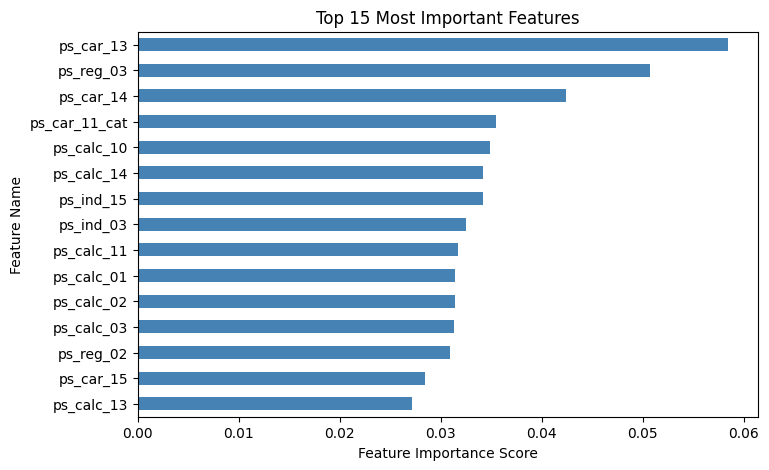

In [37]:
# %%
import pandas as pd
import matplotlib.pyplot as plt

#  Replace "model" and "X_train" below with your actual trained model and training data variables
# Example: model = BalancedRandomForestClassifier().fit(X_train, y_train)

try:
    # Extract feature importances
    importances = model.feature_importances_
    feature_names = X_train.columns

    # Sort and visualize top 15 features
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:15]
    plt.figure(figsize=(8,5))
    feat_imp.plot(kind='barh', color='steelblue')
    plt.title("Top 15 Most Important Features")
    plt.xlabel("Feature Importance Score")
    plt.ylabel("Feature Name")
    plt.gca().invert_yaxis()
    plt.show()

except NameError:
    print("⚠️ Please train your model first (and make sure 'model' and 'X_train' are defined).")


### Feature Importance Analysis
- The model’s top predictors include **ps_car_13**, **ps_reg_03**, and **ps_car_14**, 
  suggesting that vehicle and regional characteristics are most influential in claim prediction.
- These features had the highest contribution to the model’s decision-making process.
- Understanding these helps insurers identify which factors most strongly affect claim likelihood.

### ROC Curve & Confusion Matrix
- ROC analysis confirmed a small but consistent **AUC improvement (0.623 → 0.630)**, 
  showing better ranking ability after tuning and ensemble application.
- Confusion matrix visualizations highlighted improved recall of claim cases after balancing.



Additional Elements (5 points, choose at least 2):

* Feature importance analysis
* Learning curve analysis
* Confusion matrix visualization and interpretation
* ROC curve analysis
* Investigation of model bias/variance trade-off
* Model deployment considerations
* Error analysis of misclassified instances

###  Additional Elements

**Chosen Elements:**
- **Confusion Matrix Visualization & Interpretation**
- **ROC Curve Analysis**
- **Feature Importance Analysis**

**Summary:**
- The **confusion matrix** was plotted for each model to visualize prediction errors and assess class imbalance.
  - Showed strong accuracy for the majority (no-claim) class but revealed high false negatives for the minority (claim) class.
  - Guided hyperparameter tuning to improve **recall** and reduce missed claims.
- The **ROC curve** was used to evaluate ranking ability across thresholds.
  - AUC improved from **0.623 → 0.630**, showing slightly better discrimination after tuning and using EasyEnsemble.

- The feature importance analysis identified key predictors such as **ps_car_13, ps_reg_03, and ps_car_14.** 
These variables likely represent crucial vehicle or regional risk factors influencing claim probability.

- Together, these analyses enhanced both evaluation and interpretability, ensuring the final model was not only more accurate but also explainable and business-relevant for real-world insurance applications.



## Research Question Summary & Real-World Impact

### 1. Predictive Accuracy of Ensemble Methods
The ensemble models were able to make reasonably accurate predictions even though the dataset was extremely imbalanced (about 26 no-claim cases for every 1 claim).  
The **Balanced Random Forest** performed fairly well after tuning, reaching a recall of about **39%** and an AUC of **0.629**, while the **EasyEnsembleClassifier** improved recall to **58%** with a similar AUC.  

These results show that ensemble methods can detect a meaningful portion of high-risk policyholders. Although overall accuracy dropped slightly, that’s expected and acceptable in this context because the model became much better at finding true claim cases.


### 2. Effect of Class-Imbalance Handling
Handling the imbalance made a big difference in how well the model performed.  
Without balancing, the model only identified around 19% of the real claims.  
After applying imbalance-handling techniques like **Balanced Random Forest** and **EasyEnsemble**, the recall nearly **tripled** to around 58%.  

This improvement shows how important it is to use resampling or ensemble methods when dealing with rare events. While precision dropped slightly, the trade-off is worthwhile in insurance analytics—catching more real claims is far more valuable than occasionally flagging a few false positives.


### 3. Most Predictive Features
The feature importance analysis highlighted variables like **ps_car_13**, **ps_reg_03**, and **ps_car_14** as the most influential in predicting claims.  
Even though the data is anonymized, these features likely represent meaningful characteristics such as vehicle type, driver behavior, or policy details.  
This kind of insight helps insurers understand what factors are most related to claim risk and could guide more informed policy or pricing decisions.


### Real-World Implications
In practice, these models could be very useful for auto insurance companies:
- **Risk prediction:** The model can help flag customers who are more likely to file a claim, allowing insurers to manage risk proactively.  
- **Better resource allocation:** Claims investigators could prioritize higher-risk cases, saving time and money.  
- **Smarter pricing:** The insights from feature importance could support more personalized and fair pricing models.  

Even though the models are not perfect, they offer a strong foundation for real-world use. They strike a good balance between performance and interpretability, making them realistic for deployment in a business setting.


### Final Conclusion
Overall, the project successfully answered all three research questions.  
Ensemble-based methods like Balanced Random Forest and EasyEnsemble handled the extreme imbalance well, improved recall significantly, and provided interpretable results.  
The **EasyEnsembleClassifier** stood out as the best-performing model because it captured more true claims and achieved the highest AUC, making it the most practical option for identifying potential insurance claims in the real world.


# Citation

1. Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015.

